# Part 4 - Text Feature Analysis

### In this notebook, we do EDA on the "text" feature. Structurally, this part should be included in Notebook2, but we choose to present it separately after Notebook3 to provide a smoother workflow.

# Table of Contents
1. [Import Data](#section1)
2. [EDA](#section2)  
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 [Debate Participation Times by Party](#section2.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 [First speaker](#section2.2)  
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 [Channel hosting](#section2.3)

<a id="section1"></a>

# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from collections import defaultdict
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

### List of available electoral debates

In [2]:
videos = [f for f in os.listdir('videos')]
print(videos)

['ad-be', 'ad-cdu', 'ad-chega', 'ad-il', 'ad-livre', 'ad-pan', 'ad-ps', 'be-ps', 'cdu-be', 'cdu-ps', 'chega-be', 'chega-cdu', 'chega-il', 'chega-ps', 'il-be', 'il-cdu', 'il-ps', 'livre-be', 'livre-cdu', 'livre-chega', 'livre-il', 'livre-ps', 'pan-be', 'pan-cdu', 'pan-chega', 'pan-il', 'pan-livre', 'pan-ps']


In [3]:
dfs = defaultdict(pd.DataFrame)
for video in videos:
    if video != ".DS_Store":     
        df = pd.read_pickle(os.path.join('pickles', video + '.pkl'))
        df = df.sort_values(by='filename').reset_index(drop=True)
        dfs[video] = df

In [4]:
# Check the keys
dfs.keys()

dict_keys(['ad-be', 'ad-cdu', 'ad-chega', 'ad-il', 'ad-livre', 'ad-pan', 'ad-ps', 'be-ps', 'cdu-be', 'cdu-ps', 'chega-be', 'chega-cdu', 'chega-il', 'chega-ps', 'il-be', 'il-cdu', 'il-ps', 'livre-be', 'livre-cdu', 'livre-chega', 'livre-il', 'livre-ps', 'pan-be', 'pan-cdu', 'pan-chega', 'pan-il', 'pan-livre', 'pan-ps'])

<a id="section2"></a>

# 2. EDA

### Iterate over each debate to retrieve and display the text associated with specific indices. This allows us to extract and review the content displayed in each debate segment.


In [5]:
for debate, df in dfs.items():
    text = df['text'].dropna().tolist()
    if text:
        print()
        print(f"DEBATE: {debate}")
        
        # Print the first 100 rows of text
        print("First 100 rows:")
        for t in text[:100]:  # Slice the first 100 items
            print(t)
        
        # Print the last 100 rows of text if there are more than 100 rows
        if len(text) > 100:
            print("\nLast 100 rows:")
            for t in text[-100:]:  # Slice the last 100 items
                print(t)
        else:
            print("\nLess than 100 rows total, showing only the first 50 rows.")
        
        print()



DEBATE: ad-be
First 100 rows:
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

Last 100 rows:
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


DEBATE: ad-cdu
First 100 rows:
['Hl;', "'=3", 'U']
['H7G', 'VA', '=3']
['3']
['3']
['73']
['23', 'AP']
['=3', 'AP', '2124', 'LEGISLATIVAS']
['3', 'AP', 'DEE', '2424', 'LEGISLATIVAS']
['3', 'DEBATE', '2424', 'LEGISLATIVAS']
['3', 'DEBATE', 'LEGISLATIVAS', '2024']
['n']
['23', '9', 'EsuTAS', 'ª', '9', '[2524']
['3', '2624', 'Cslatwas', '77', 'ª', '9',

### We identify significant challenges, including spelling errors and incomplete information, which impact the comprehensibility of the data. Despite these issues, this analysis is crucial for understanding the engagement level and contribution of each participant in the debates.

### Using the data retrieved we create a dictionary with the information

In [6]:
data = {
    "Debate": ["AD PS", "BE PS", "PS PAN", "AD CDU", "CHEGA BE", "AD CHEGA", "LIVRE PS", "IL CDU", "AD IL", "PAN CDU", "PAN CHEGA"],
    "Party1": ["AD", "BE", "PS", "AD", "CHEGA", "AD", "LIVRE", "IL", "AD", "PAN", "PAN"],
    "Party2": ["PS", "PS", "PAN", "CDU", "BE", "CHEGA", "PS", "CDU", "IL", "CDU", "CHEGA"],
    "First_speaker": ["AD", "PS", "PAN", "CDU", "BE", "AD", "LIVRE", "IL", "AD", "PAN", "CHEGA"],
    "Channel": ["RTP", "RTP", "CNN", "RTP", "RTP", "RTP", "RTP", "RTP", "SIC", "RTP", "RTP" ],
    "Time1": ["39:34", "15:08", "11:38", "13:08", "18:14", "19:27", "13:14", "14:44", "13:11", "10:45", "13:30"],
    "Time2": ["38:04", "15:06", "11:40", "13:53", "17:53", "19:28", "14:36", "14:25", "13:37", "11:06", "13:45"]
}

In [7]:
# Function to convert time string to total minutes
def time_to_minutes(t):
    minutes, seconds = map(int, t.split(':'))
    return minutes + seconds / 60

In [8]:
df = pd.DataFrame(data)

# Apply conversion to each time entry
df['Time1'] = df['Time1'].apply(time_to_minutes)
df['Time2'] = df['Time2'].apply(time_to_minutes)

print(df)

       Debate Party1 Party2 First_speaker Channel      Time1      Time2
0       AD PS     AD     PS            AD     RTP  39.566667  38.066667
1       BE PS     BE     PS            PS     RTP  15.133333  15.100000
2      PS PAN     PS    PAN           PAN     CNN  11.633333  11.666667
3      AD CDU     AD    CDU           CDU     RTP  13.133333  13.883333
4    CHEGA BE  CHEGA     BE            BE     RTP  18.233333  17.883333
5    AD CHEGA     AD  CHEGA            AD     RTP  19.450000  19.466667
6    LIVRE PS  LIVRE     PS         LIVRE     RTP  13.233333  14.600000
7      IL CDU     IL    CDU            IL     RTP  14.733333  14.416667
8       AD IL     AD     IL            AD     SIC  13.183333  13.616667
9     PAN CDU    PAN    CDU           PAN     RTP  10.750000  11.100000
10  PAN CHEGA    PAN  CHEGA         CHEGA     RTP  13.500000  13.750000


In [9]:
# Party to color mapping
party_colors = {
    'AD': 'orange',
    'PS': 'red',
    'BE': 'darkred',
    'PAN': 'green',
    'CDU': 'brown',
    'CHEGA': 'purple',
    'LIVRE': 'pink',
    'IL': 'lightblue'
}

<a id="section2.1"></a>

## 2.1 Debate Participation Times by Party

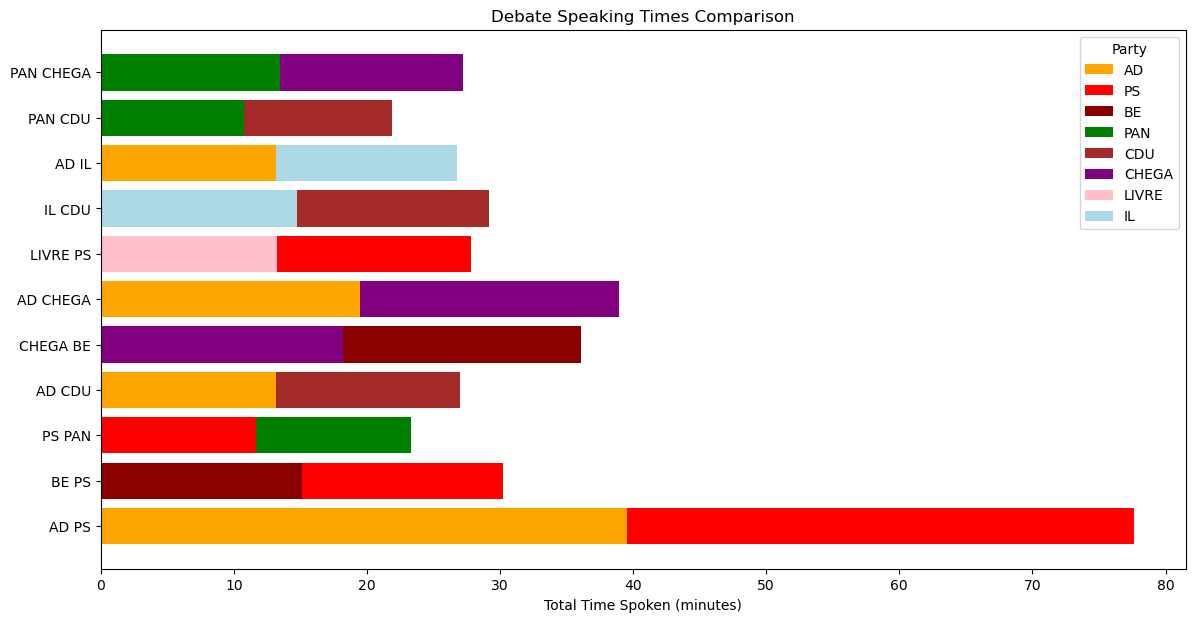

In [10]:
fig, ax = plt.subplots(figsize=(14, 7))

for index, row in df.iterrows():
    # Get colors from dictionary
    color1 = party_colors.get(row['Party1'], 'black')  # Default to black if party not found
    color2 = party_colors.get(row['Party2'], 'black')
    
    # Plot each party's time with corresponding color
    ax.barh(row['Debate'], row['Time1'], color=color1, label=row['Party1'] if row['Party1'] not in ax.get_legend_handles_labels()[1] else "")
    ax.barh(row['Debate'], row['Time2'], left=row['Time1'], color=color2, label=row['Party2'] if row['Party2'] not in ax.get_legend_handles_labels()[1] else "")

ax.set_xlabel('Total Time Spoken (minutes)')
ax.set_title('Debate Speaking Times Comparison')
ax.legend(title="Party")

plt.show()

<a id="section2.2"></a>

## 2.2 First speaker

###  This plot determines the frequency that each party started the debate.

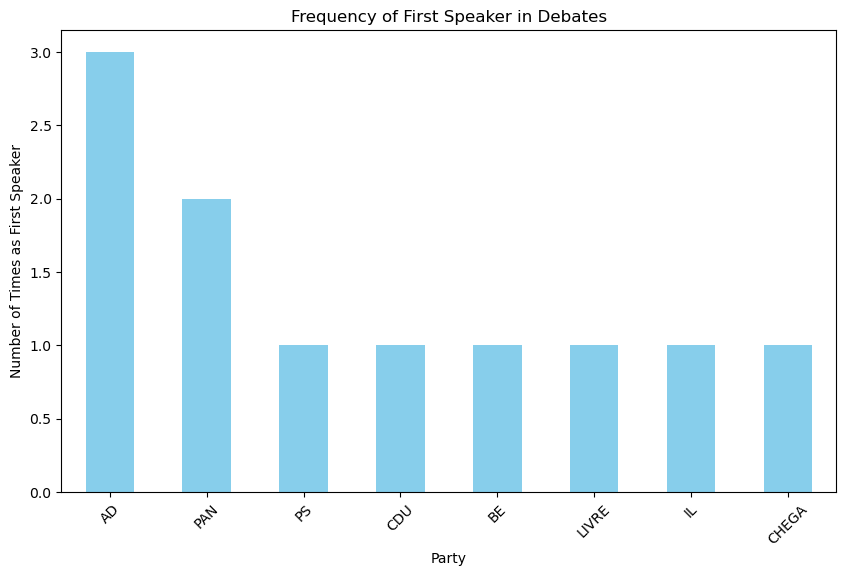

In [11]:
# Count the number of times each party was the first speaker
first_speaker_counts = df['First_speaker'].value_counts()

# Plotting a bar chart
plt.figure(figsize=(10, 6))
first_speaker_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of First Speaker in Debates')
plt.xlabel('Party')
plt.ylabel('Number of Times as First Speaker')
plt.xticks(rotation=45)
plt.show()

<a id="section2.2"></a>

## 2.3 Channel hosting

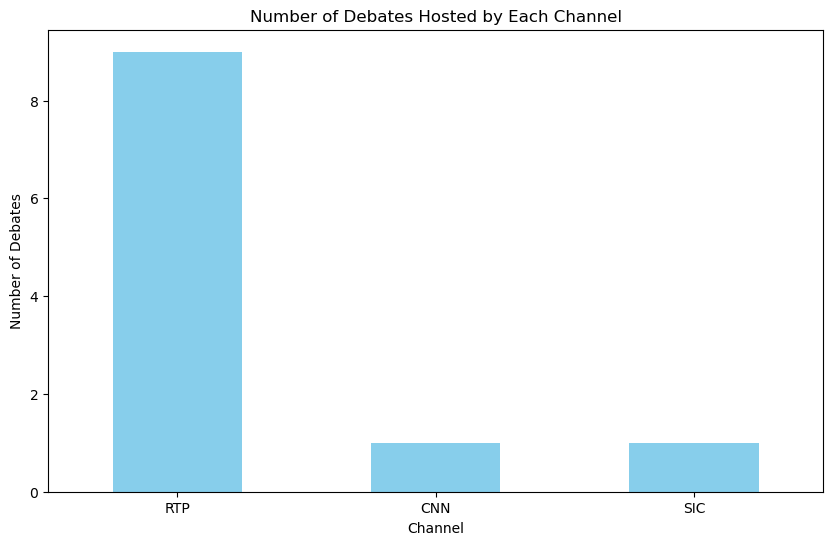

In [12]:
# Count the number of debates hosted by each channel
channel_counts = df['Channel'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
channel_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Debates Hosted by Each Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Debates')
plt.xticks(rotation=0)  # Keep the channel names horizontal for better readability
plt.show()

------------------------------
# Authors
<p style="font-size: 20px; line-height: 1.2;">
<strong>Diogo Miranda (96190)</strong><br>
<strong>João Martins (99983)</strong><br>
<strong>Miguel Bandeira (100035)</strong>
</p>